In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import SGD, Adagrad, RMSprop, Adam, Adadelta, Nadam

import matplotlib.pyplot as plt
import math

import talib

Using TensorFlow backend.
c:\programdata\anaconda3\envs\upbit\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\programdata\anaconda3\envs\upbit\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\programdata\anaconda3\envs\upbit\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\programdata\anaconda3\envs\upbit\lib\site-pa

In [2]:
look_back = 1
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)
 
# file loader
df = pd.read_csv("C:\\Users\\ojkk3\\PycharmProjects\\coin_crawler\\data\\upbit_KRW_XRP_minutes_15.csv", index_col="date")
df['close']

date
2020-03-14T10:00:00+00:00    191.0
2020-03-14T09:45:00+00:00    191.0
2020-03-14T09:30:00+00:00    193.0
2020-03-14T09:15:00+00:00    193.0
2020-03-14T09:00:00+00:00    195.0
                             ...  
2018-03-14T01:00:00+00:00    869.0
2018-03-14T00:45:00+00:00    869.0
2018-03-14T00:30:00+00:00    860.0
2018-03-14T00:15:00+00:00    862.0
2018-03-14T00:00:00+00:00    864.0
Name: close, Length: 70015, dtype: float64

In [3]:
df

,open,high,low,close,volume
date,,,,,
2020-03-14T10:00:00+00:00,192.0,193.0,191.0,191.0,6.302633e+05
2020-03-14T09:45:00+00:00,192.0,193.0,190.0,191.0,3.147385e+06
2020-03-14T09:30:00+00:00,194.0,195.0,193.0,193.0,1.293161e+06
2020-03-14T09:15:00+00:00,195.0,195.0,193.0,193.0,1.196142e+06
2020-03-14T09:00:00+00:00,195.0,195.0,193.0,195.0,1.788169e+06
...,...,...,...,...,...
2018-03-14T01:00:00+00:00,869.0,870.0,866.0,869.0,5.122584e+05
2018-03-14T00:45:00+00:00,860.0,872.0,859.0,869.0,1.058177e+06
2018-03-14T00:30:00+00:00,862.0,863.0,858.0,860.0,4.926290e+05


In [4]:
 # convert nparray
nparr = df[['close']].values[::-1]
nparr

array([[864.],
       [862.],
       [860.],
       ...,
       [193.],
       [191.],
       [191.]])

In [11]:
nparr = nparr.astype('float32')
nparr

array([[864.],
       [862.],
       [860.],
       ...,
       [193.],
       [191.],
       [191.]], dtype=float32)

In [12]:
# normalization
scaler = MinMaxScaler(feature_range=(0, 1))
ndf = scaler.fit_transform(nparr)

In [14]:
# split train, test
train_size = int(len(ndf) * 0.95)
test_size = len(ndf) - train_size
train, test = ndf[0:train_size], ndf[train_size:len(ndf)]
print(len(train), len(test))

66514 3501


In [15]:
# create dataset for learning
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [16]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
"""
model = Sequential()

model.add(LSTM(128, input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2)) #오버피팅을 막고자 일부를 버림
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.2))

model.add(LeakyReLU(alpha=0.1))

model.add(Dense(1, activation='relu'))

opt = Adam(lr=0.001, decay=1e-6)
#opt = Nadam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

model.compile(loss='mean_squared_error', optimizer=opt)
model.fit(trainX, trainY, epochs=5, batch_size=128, verbose=1)
"""

In [17]:
opt = Adam(lr=0.001)

# simple lstm network learning
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back)))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

history = model.fit(
    trainX, trainY, 
    epochs=20, 
    batch_size=512, 
    validation_data = (testX, testY),
    verbose=1)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 66512 samples, validate on 3499 samples
Epoch 1/20
66512/66512 [==============================] - 1s 11us/step - loss: 0.0326 - acc: 0.0000e+00 - val_loss: 0.0100 - val_acc: 2.8580e-04
Epoch 2/20
66512/66512 [==============================] - 0s 4us/step - loss: 0.0048 - acc: 1.5035e-05 - val_loss: 0.0013 - val_acc: 2.8580e-04
Epoch 3/20
66512/66512 [==============================] - 0s 4us/step - loss: 2.1928e-04 - acc: 1.5035e-05 - val_loss: 4.8525e-05 - val_acc: 2.8580e-04
Epoch 4/20
66512/66512 [==============================] - 0s 4us/step - loss: 4.5090e-05 - acc: 1.5035e-05 - val_loss: 3.6324e-05 - val_acc: 2.8580e-04
Epoch 5/20
66512/66512 [==============================] - 0s 4us/step - loss: 4.2057e-05 - acc: 1.5035e-05 - val_loss: 3.3147e-05 - val_acc: 2.8580e-04
Epoch 6/20
66512/66512 [==============================] - 0s 4us/step - loss: 3.8914e-05 - acc: 1.5035e-05

In [18]:
# make prediction
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)

Train Score: 1.92 RMSE


In [20]:
# predict last value (or tomorrow?)
lastX = ndf[-1]
lastX = np.reshape(lastX, (1, 1, 1))
lastY = model.predict(lastX)
lastY = scaler.inverse_transform(lastY)
print('Predict the Close value of final day: %d' % lastY)  # 데이터 입력 마지막 다음날 종가 예측

Predict the Close value of final day: 193


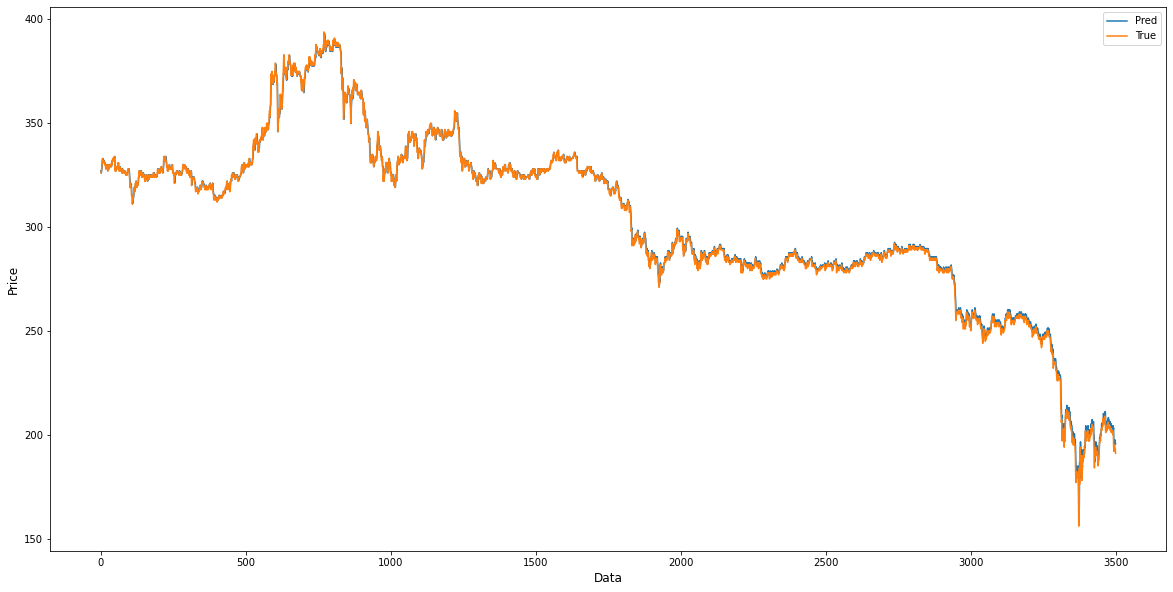

In [21]:
# 시각화
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
plt.plot(testPredict,label='Pred')
plt.plot(testY,label='True')
ax.legend()
plt.xlabel('Data', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()